In [1]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
from scipy.spatial import cKDTree
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner, LampeRunner
from ili.embedding import GraphNetwork
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
from ili.dataloaders import TorchLoader

from typing import *
from pathlib import Path

from torch_geometric.data import Data, Dataset
from torch.utils.data import DataLoader
from torch_geometric.loader.dataloader import Collater

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


In [2]:
# check n neighbours is reasonable
# add velocity as feature
# add aggregators option
# add attention option

In [3]:

def load_parameters(
    data_dir, param_file: str, nodes: List[int], param_names: List[str]
) -> np.array:
    """Get parameters for nodes

    Args:
        param_file (str): where to find parameters of latin hypercube
        nodes (List[int]): list of nodes to read
        param_names (List[str]): parameters to use

    Returns:
        np.array: array of parameters
    """
    theta = pd.read_csv(
        data_dir / param_file, sep=" ", skipinitialspace=True
    ).iloc[nodes]
    return theta[param_names].values

import readfof


def load_sim(
    node: int,
    redshift: float,
    path_to_lhcs: Path,
) -> Tuple[np.array, np.array, np.array]:
    """load quijote simulationsn from latin hypercube

    Args:
        node (int): node to read
        redshift (float): redshift to read
        path_to_lhcs (_type_, optional): Path to where latin hypercubes are stored.

    Returns:
        pos (np.array): array of halo positions (in Mpc/h)
        vel (np.array): array of halo velocities (in km/s)
        mass (np.array): array of halo masses (in Msun/h)
    """
    snapshot_dict = {0.0: 4, 0.5: 3, 1.0: 2, 2.0: 1, 3.0: 0}
    FoF = readfof.FoF_catalog(
        str(path_to_lhcs / f"{node}/"), 
        snapshot_dict[redshift],
        long_ids=False,
        swap=False,
        SFR=False,
        read_IDs=False,
    )
    pos = FoF.GroupPos / 1e3
    vel = FoF.GroupVel * (1.0 + redshift)
    mass = FoF.GroupMass * 1e10
    return pos, vel, mass

def get_halo_positions(
    path_to_lhcs, nodes: List[int], redshift= 0., n_halos=1_000,
) -> np.array:
    positions = []
    for node in nodes:
        pos, vel, mass = load_sim(
            node=node, redshift=redshift, path_to_lhcs=path_to_lhcs
        )
        sorted_mass_idx = np.argsort(mass)
        pos = pos[sorted_mass_idx][-n_halos:, :]
        positions.append(pos)
    return np.array(positions)

In [21]:
class GraphDataset(Dataset):
    def __init__(self, positions, theta, boxsize, radius,):
        super().__init__()
        self.positions = torch.Tensor(positions.astype(np.float32))
        self.theta = torch.Tensor(theta.astype(np.float32))
        self.boxsize = boxsize
        self.radius = radius
        self.data_list = self.process_positions()

    def process_positions(self):
        data_list = []
        for idx, pos in enumerate(self.positions):
            pos %= self.boxsize
            tree = cKDTree(pos, boxsize=self.boxsize)
            neighbors = tree.query_ball_tree(tree, r=self.radius)
            # Generate edge pairs (i, j), remove self loops
            edge_index = [(i, j) for i, neighbors_i in enumerate(neighbors) for j in neighbors_i if i != j]
            edge_index = torch.tensor(edge_index, dtype=torch.int64).T
            dr = pos[edge_index[0]] - pos[edge_index[1]]
            # correct with periodic boundary conditions
            dr = (dr + self.boxsize/2) % self.boxsize - self.boxsize/2
            d = torch.sqrt(torch.sum(dr**2, axis=1))
            edge_attr = torch.hstack((dr, d.unsqueeze(1)))
            edge_attr /= self.radius
            data = Data(edge_attr=edge_attr, edge_index=edge_index, y = self.theta[idx])
            data_list.append(data)
        return data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        data = self.data_list[idx]
        return data, data.y



In [9]:
batch_size = 32 

In [10]:
data_dir = Path('/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/quijote/latin_hypercube/')
boxsize=1000.
radius = 15.
n_halos = 10_000
nodes = range(1800)
val_nodes = range(1800, 2000)
train_positions = get_halo_positions(data_dir, nodes=nodes, n_halos=n_halos,)
train_theta = load_parameters(data_dir, param_file='latin_hypercube_params.txt', nodes=nodes, param_names=['Omega_m', 'sigma_8',])

val_positions = get_halo_positions(data_dir, nodes=val_nodes, n_halos=n_halos,)
val_theta = load_parameters(data_dir, param_file='latin_hypercube_params.txt', nodes=val_nodes, param_names=['Omega_m', 'sigma_8',])

In [22]:

train_dataset = GraphDataset(train_positions, train_theta, boxsize, radius)
val_dataset = GraphDataset(val_positions, val_theta, boxsize, radius)

In [23]:
len(train_dataset), len(val_dataset)

(1800, 200)

In [24]:
collater = Collater(train_dataset[0])

# output (input, output) pairs
def collate_fn(batch):
    return collater(batch)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn,)
loader = TorchLoader(train_loader, val_loader)

In [29]:
summary_dim = 200 
model = GraphNetwork(
    node_features_dim = None,
    edge_features_dim = 4,
    node_features_hidden_dim =128, 
    edge_features_hidden_dim =128,
    global_output_dim = summary_dim,
    message_passing_steps = 2,
)

In [30]:
model = model.to(device)

Step 0, loss 0.008396098390221596


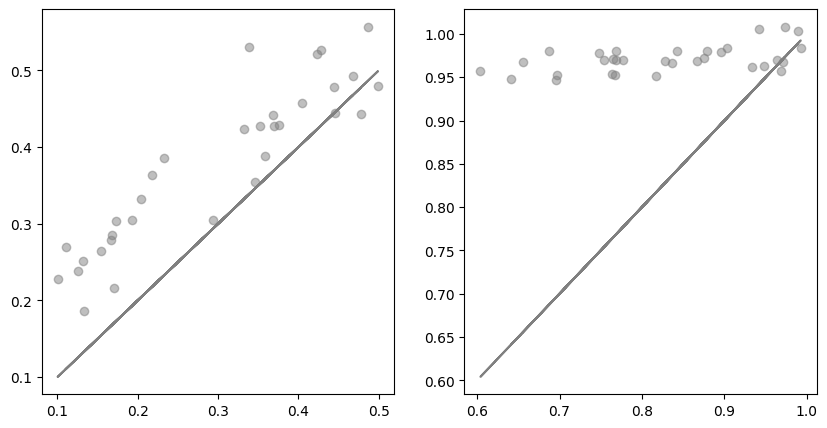

Step 100, loss 0.007337930612266064


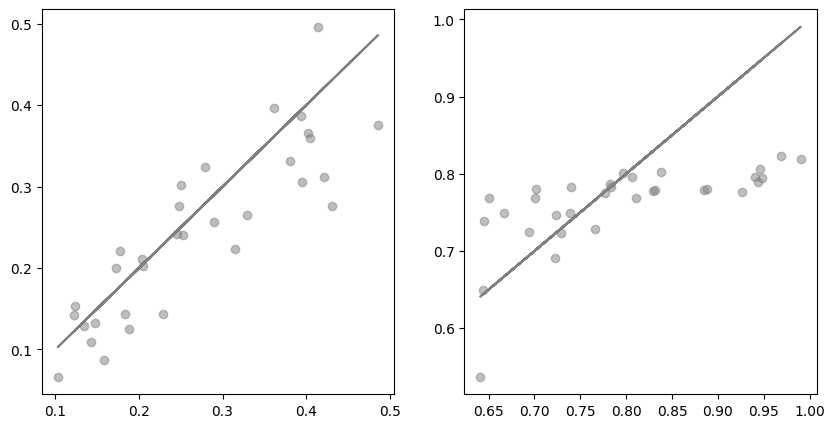

Step 200, loss 0.008873946964740753


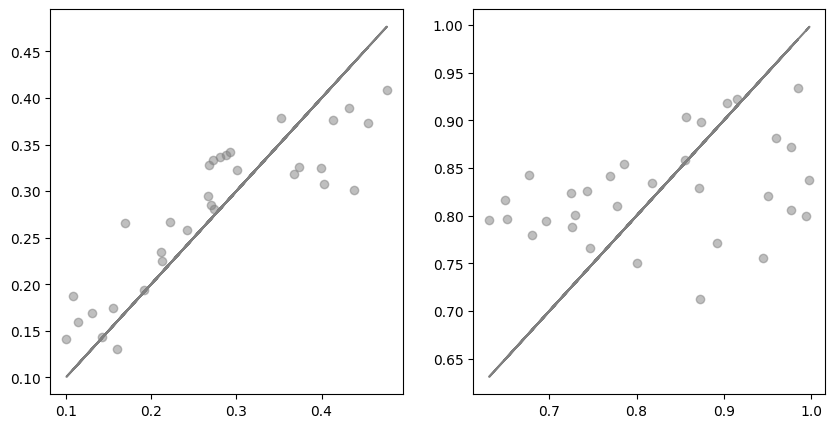

Step 300, loss 0.0056632026098668575


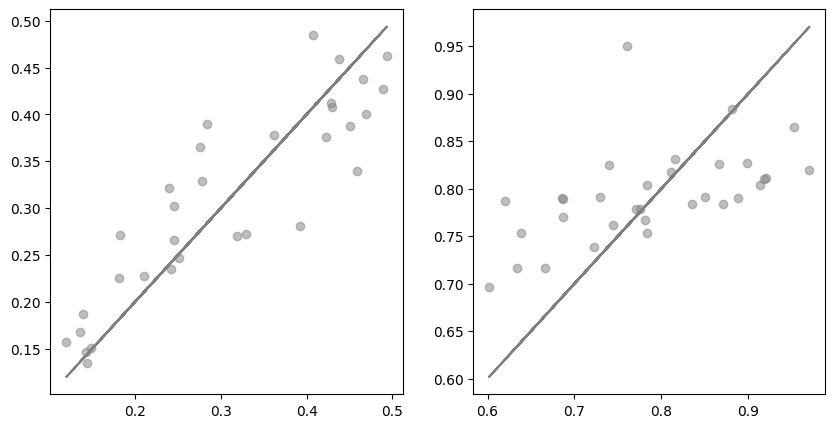

Step 400, loss 0.005469230003654957


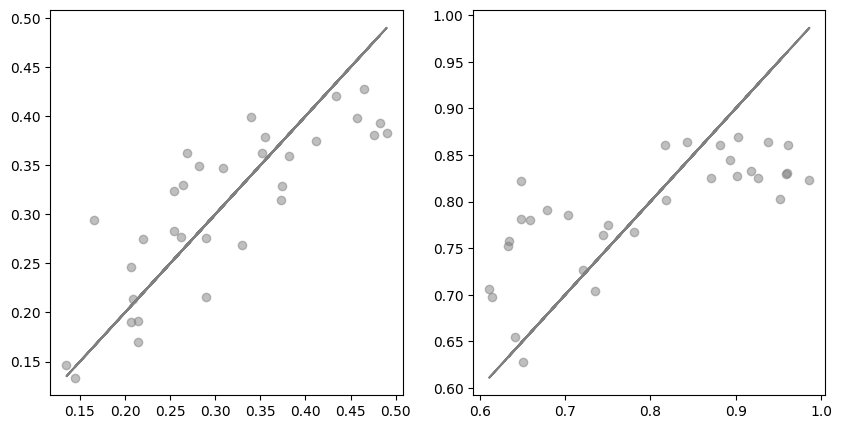

Step 500, loss 0.004767956677824259


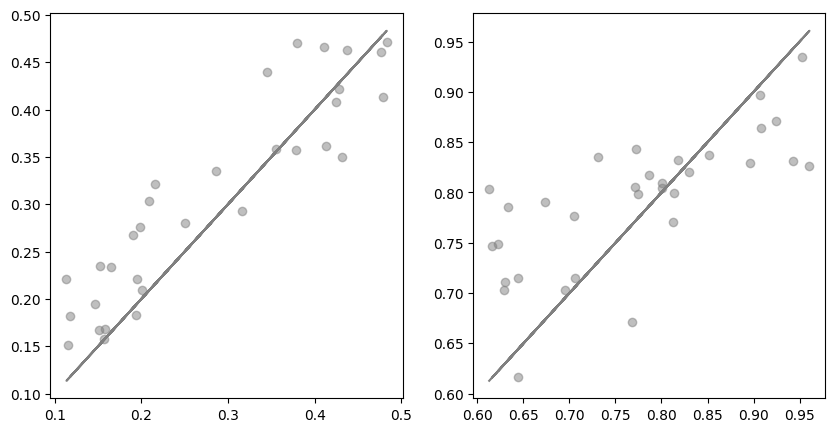

Step 600, loss 0.005842401646077633


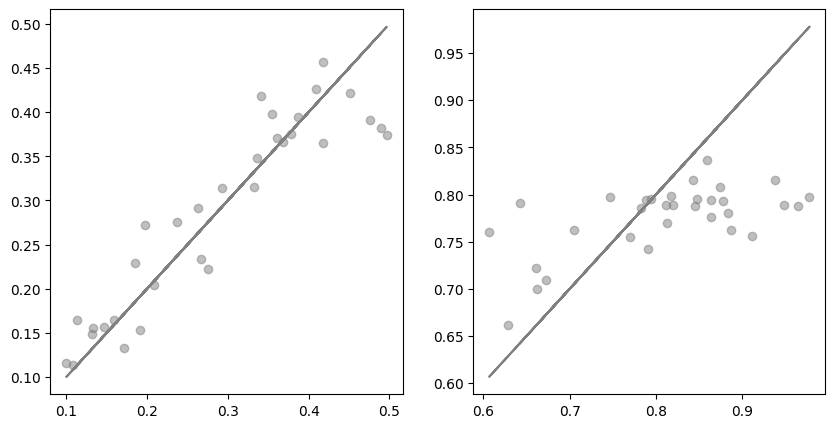

Step 700, loss 0.005358468741178513


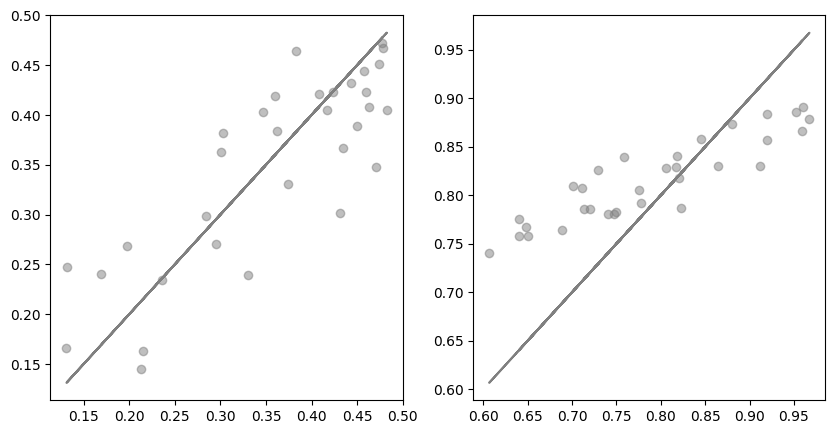

Step 800, loss 0.001521829515695572


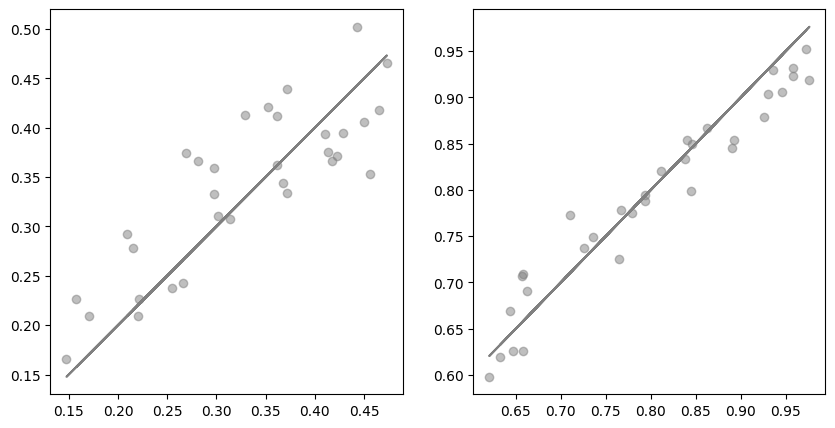

Step 900, loss 0.0023620345164090395


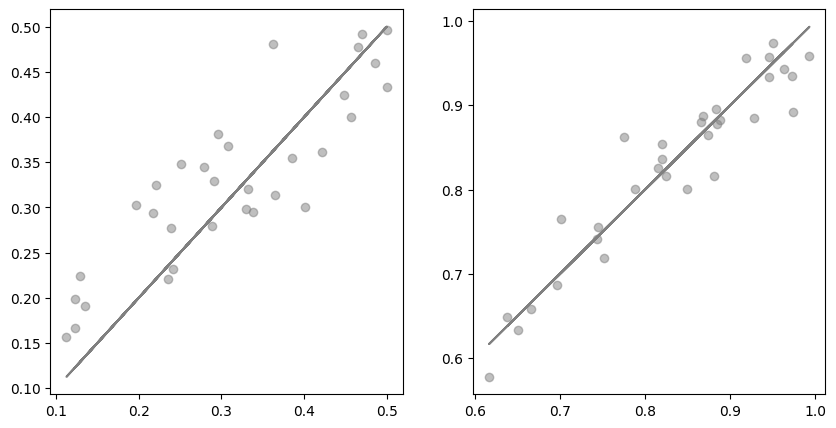

Step 1000, loss 0.0018945990595966578


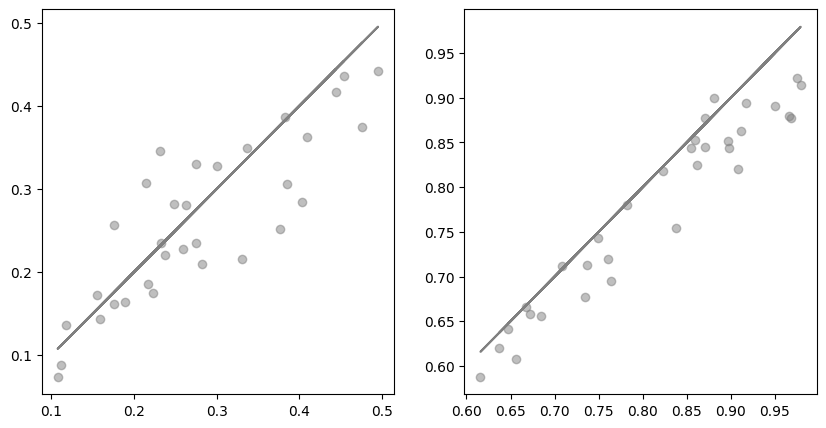

Step 1100, loss 0.0013117007911205292


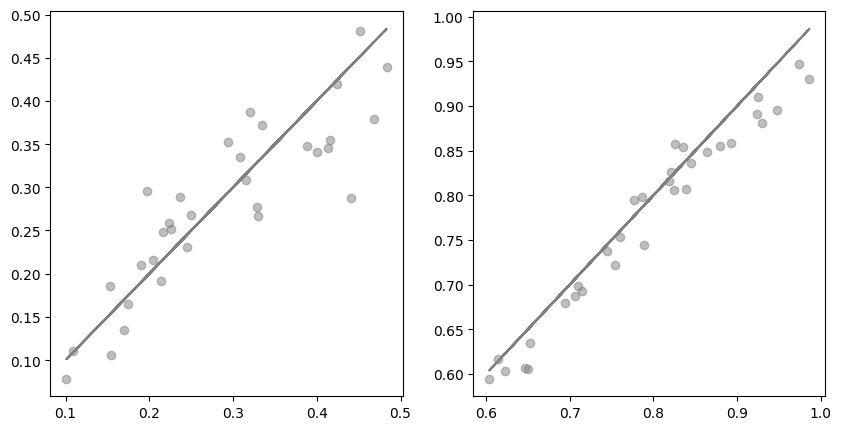

Step 1200, loss 0.001820418518036604


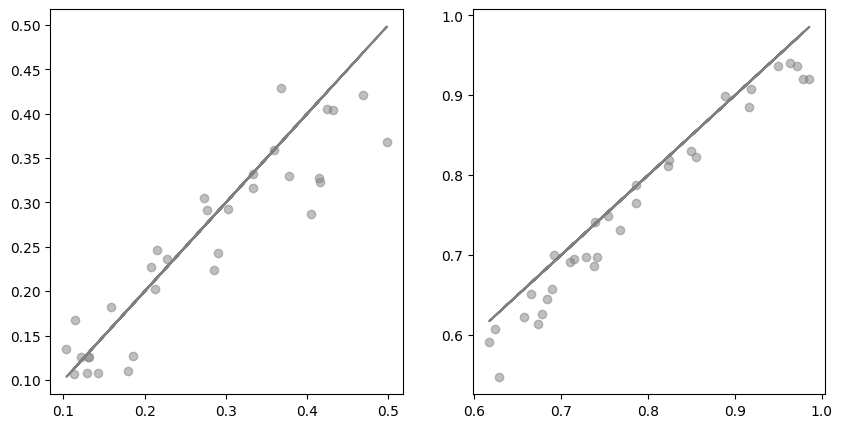

Step 1300, loss 0.0025132782757282257


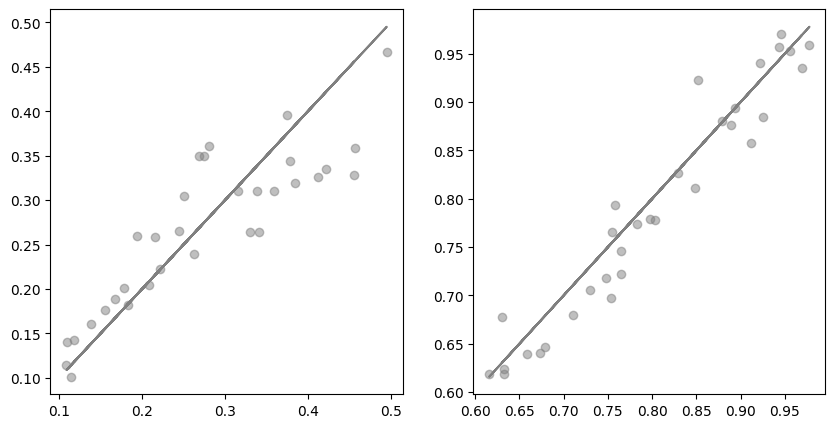

Step 1400, loss 0.0014152169460430741


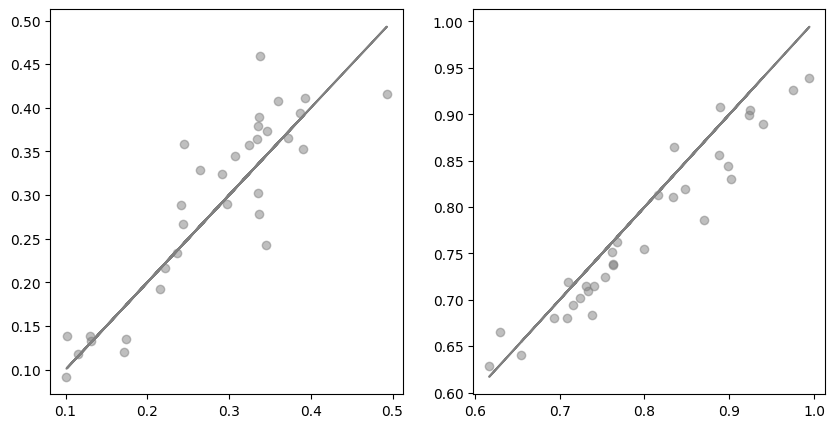

Step 1500, loss 0.0021968104410916567


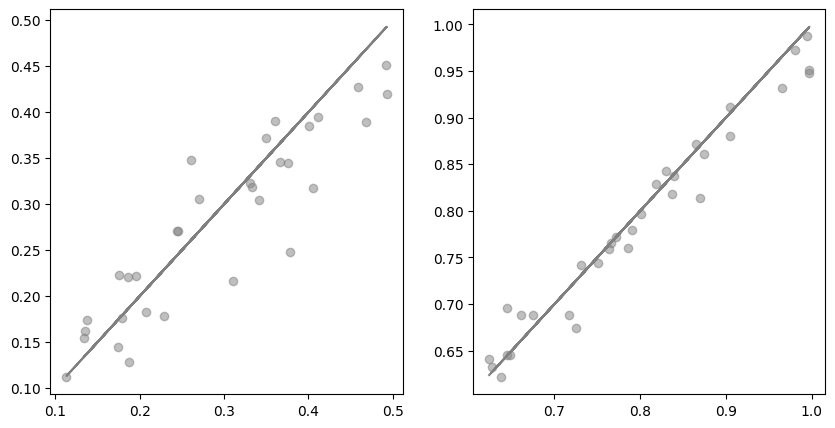

Step 1600, loss 0.0016706000315025449


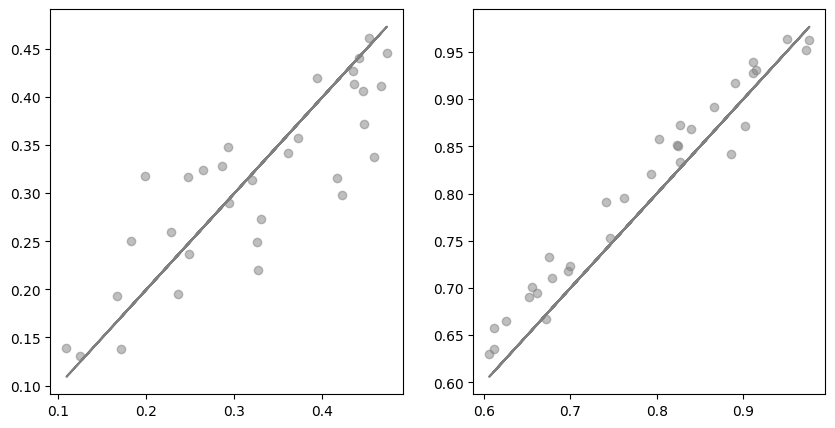

Step 1700, loss 0.001865169731900096


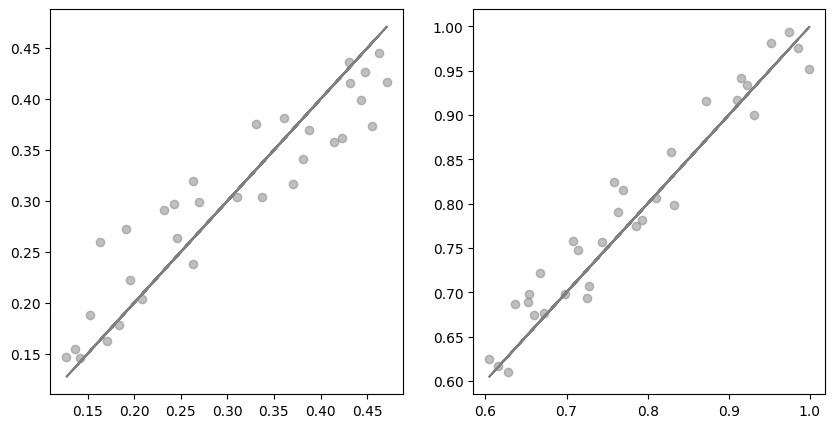

Step 1800, loss 0.0019808937795460224


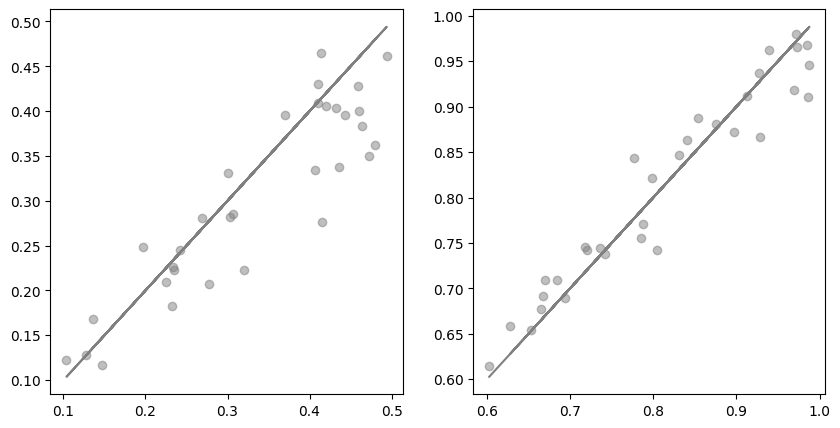

Step 1900, loss 0.0014830869622528553


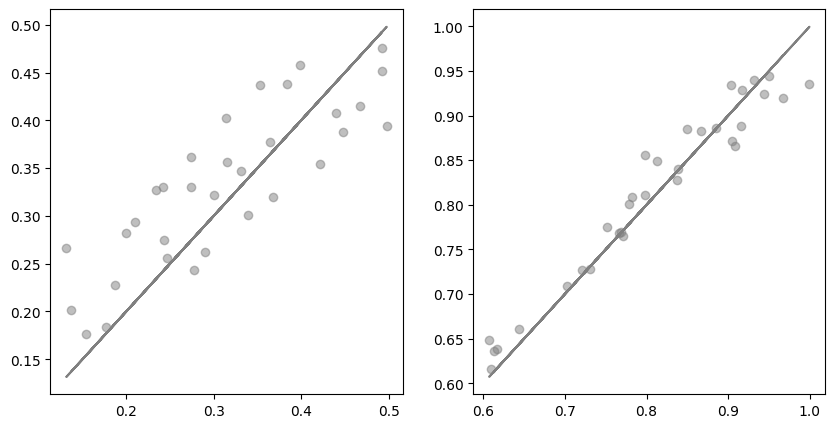

Step 2000, loss 0.0014266350772231817


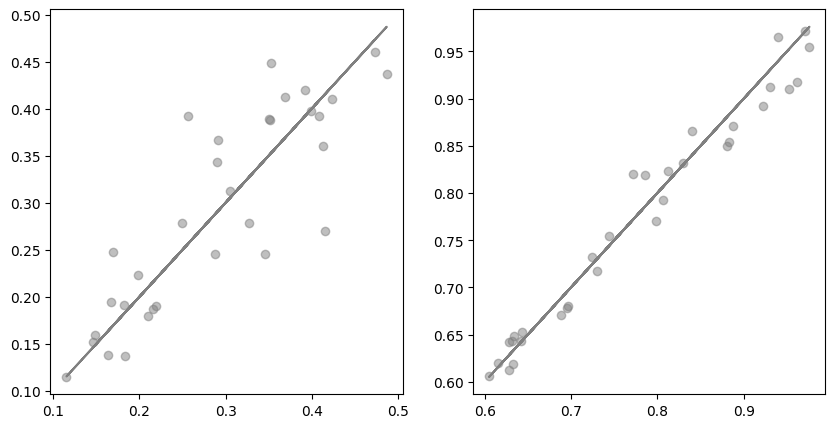

KeyboardInterrupt: 

In [28]:
# train to regress Omega matter, test on validation
from torch import optim

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1.e-3)
n_steps = 10_000 

for step in range(n_steps):
    graph, theta = next(iter(train_loader))
    graph = graph.to(device)
    theta = theta.to(device)
    outputs = model(graph)
    loss = criterion(outputs, theta)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 
    if step % 100 == 0:
        print(f"Step {step}, loss {loss.item()}")
        graph, theta = next(iter(train_loader))
        graph = graph.to(device)
        outputs = model(graph)
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        for i in range(2):
            ax[i].plot(
                theta.cpu().detach().numpy()[:,i], 
                theta.cpu().detach().numpy()[:,i], 
                color='gray',
            )
            ax[i].plot(theta.cpu().detach().numpy()[:,i], outputs.cpu().detach().numpy()[:,i], 'o', color='gray', alpha=0.5)
        plt.show()



In [ ]:

param_file='latin_hypercube_params.txt'
pd.read_csv(
        data_dir / param_file, sep=" ", skipinitialspace=True
    ).max()
    

Omega_m    0.49990
Omega_b    0.06999
h          0.89990
n_s        1.19990
sigma_8    0.99990
dtype: float64

In [31]:
nets = [
    ili.utils.load_nde_lampe(model='maf', hidden_features=50, num_transforms=5, embedding_net=model, x_normalize=False,),
    ili.utils.load_nde_lampe(model='maf', hidden_features=50, num_transforms=5, embedding_net=model, x_normalize=False,),
    #ili.utils.load_nde_lampe(model='maf', hidden_features=50, num_transforms=5, embedding_net=model, x_normalize=False,),
    #ili.utils.load_nde_lampe(model='maf', hidden_features=50, num_transforms=5, embedding_net=model, x_normalize=False,),
]


In [32]:

prior = ili.utils.Uniform(low=[0.1, 0.6,], high=[0.5, 1.,], device=device)
train_args = {
    'training_batch_size': batch_size,
    'learning_rate': 2e-4,
    'stop_after_epochs': 100,
}


In [33]:
# initialize the trainer
runner = InferenceRunner.load(
    backend='lampe',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=model,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [34]:
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 4.


79 epochs [05:36,  4.26s/ epochs, loss=1.97, loss_val=2.16]
INFO:root:Training model 2 / 4.
205 epochs [15:00,  4.39s/ epochs, loss=0.411, loss_val=0.392]


KeyboardInterrupt: 

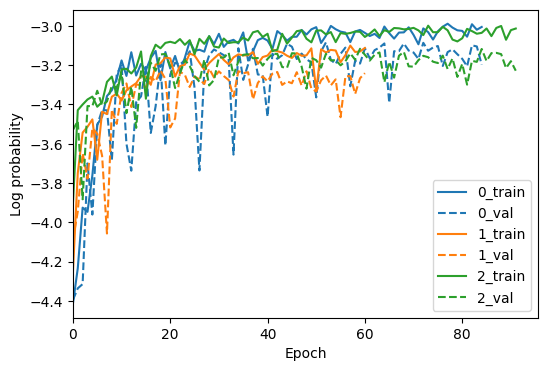

In [ ]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [ ]:
# Now, LampeRunner returns a custom class instance to be able to pass signature strings
# This class has simply for attributes a NeuralPosteriorEstimate and a string list 
print(posterior_ensemble.signatures)

# choose a random input
seed_in = None
np.random.seed(seed_in)
ind = np.random.randint(len(val_dataset))
x_ = val_dataset[ind][0]
y_ = val_dataset[ind][1]
dim_theta = y_.shape[-1]

# generate samples from the posterior using accept/reject sampling
seed_samp = 1234
torch.manual_seed(seed_samp)
samples = posterior_ensemble.sample((1000,), val_dataset[ind][0])



INFO:root:Sampling models with tensor([352., 308., 340.], device='cuda:0') samples each.


['', '', '']


Drawing 352 posterior samples:   0%|          | 0/352 [00:00<?, ?it/s]

Drawing 352 posterior samples:   0%|          | 0/352 [29:39<?, ?it/s]

In [ ]:
# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, val_dataset[ind][0])

y_ = y_.cpu()#.numpy()
samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

INFO:root:Sampling models with tensor([453., 547.], device='cuda:0') samples each.
Drawing 453 posterior samples: 646it [00:00, 47243.69it/s]            
Drawing 547 posterior samples: 993it [00:00, 152645.92it/s]           


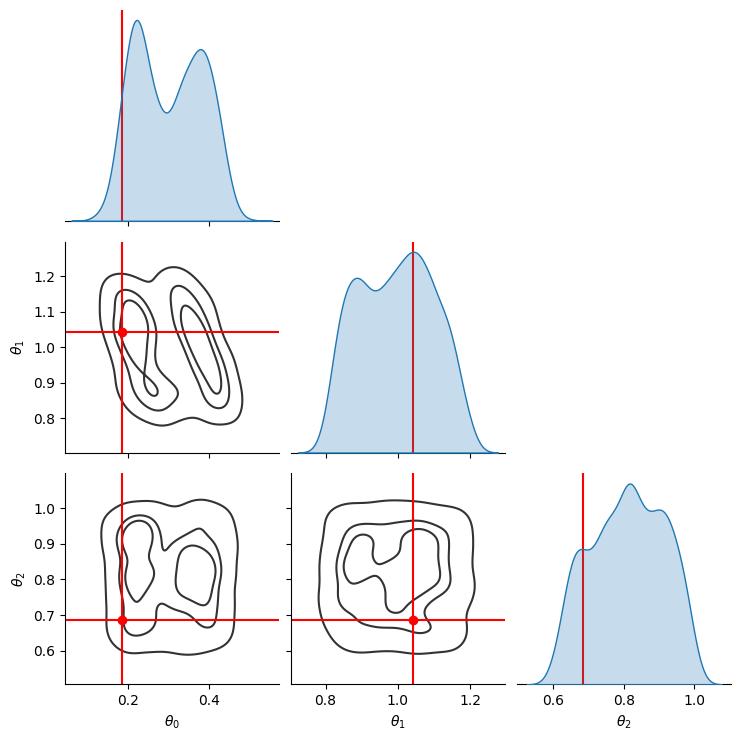

In [ ]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(dim_theta)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x_, theta_fid=y_
)

100%|██████████| 100/100 [00:00<00:00, 141.04it/s]


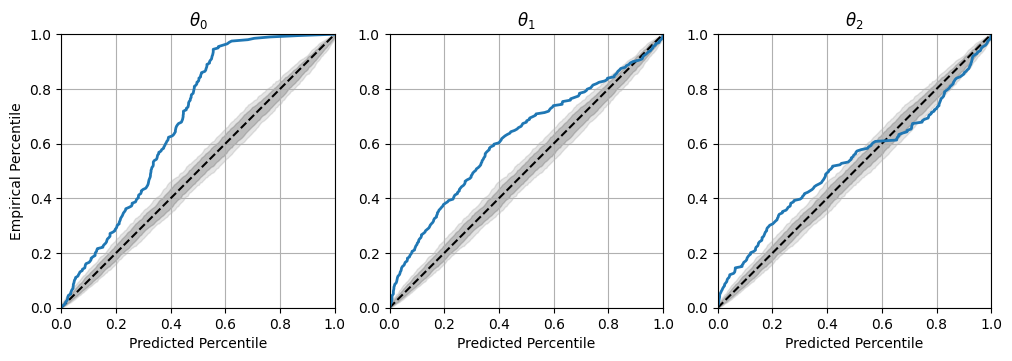

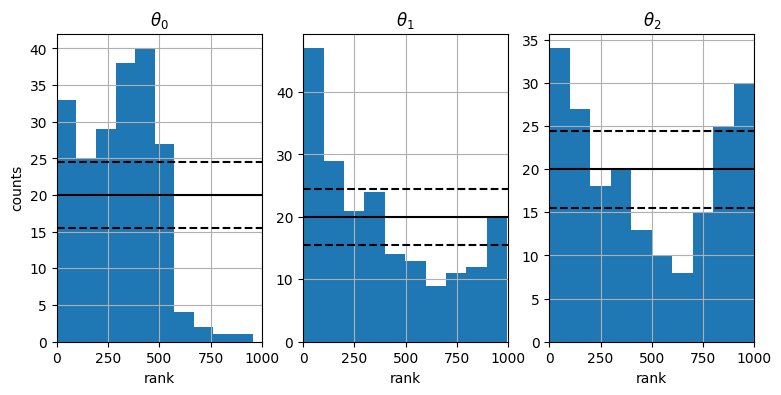

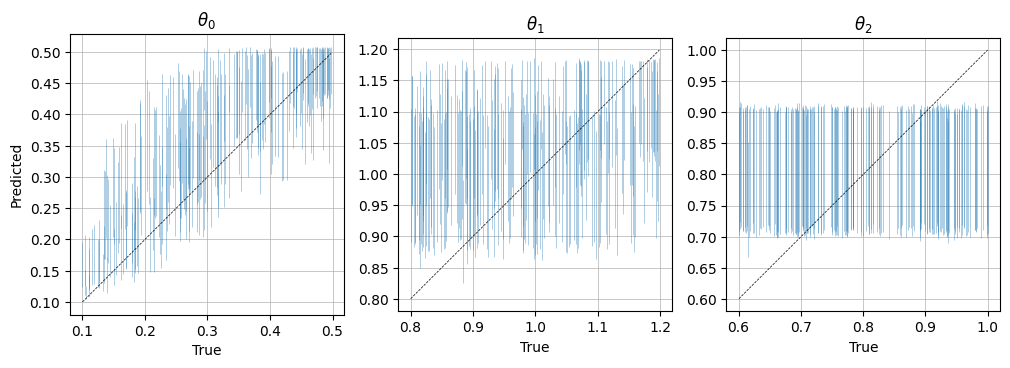

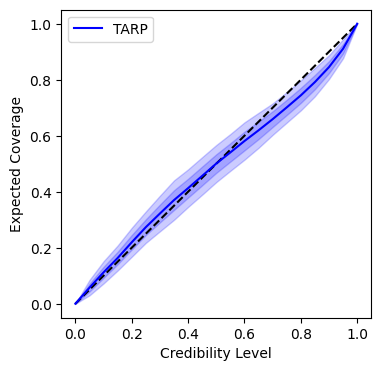

In [ ]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(dim_theta)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=val_dataset.data_list, theta=val_theta,
)